# Step 1: Installing and Importing the dependencies and packages¶

 Packages used are :
1) Open CV
2) Media Pipe
3) Matplotlib
4) Scikit-learn
5) Tensorflow¶

In [1]:
import tensorflow as tf 

In [2]:
!pip install opencv-python mediapipe scikit-learn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Step2 : Using MP Holistics from Mediapoints to create keypoints¶

In [4]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #COLOR CONVERSION BGR TO RGB
    image.flags.writeable = False               # Image is no longer writeable
    results = model.process(image)              # Make prediction
    image.flags.writeable= True                 # Image is now writavle
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB TO BGR
    return image,results

In [5]:
mp_holistic = mp.solutions.holistic    # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)       # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)       # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face contours
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connectionsFACEMESH_CONTOURS
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

 # Step 3: Extract keypoints

In [8]:
def extract_keypoints(results):
    pose=np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face=np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh= np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

#  Step 4: Setup folders for Collection

In [9]:
DATA_PATH = os.path.join('Action_Data') 

# Actions that we try to detect
actions = np.array(['nice to meet you','thanks'])

# Thirty videos worth of data
no_sequences = 30
# Videos are going to be 30 frames in length
sequence_length = 30

In [54]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Step 5: Collect Keypoints for Training and Testing 

In [13]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [12]:
cap.release()
cv2.destroyAllWindows()

#  Step 6 : Preprocess Data And Create Labels

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'nice to meet you': 0, 'thanks': 1}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
np.array(sequences).shape

(60, 30, 1662)

In [15]:
X = np.array(sequences)

In [16]:
y = to_categorical(labels).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [18]:
y_test.shape

(3, 2)

# Step 7 : Build and Train LSTM Neural Network 

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [47]:
log_dir = os.path.join('Log')
tb_callback = TensorBoard(log_dir=log_dir)

In [48]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [50]:
res = [.5, 0.2, 0.1]

In [51]:
actions[np.argmax(res)]

'nice to meet you'

In [52]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [53]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
2/2 [==============================] - 14s 179ms/step - loss: 4.7518 - categorical_accuracy: 0.5088
Epoch 2/2000
2/2 [==============================] - 0s 186ms/step - loss: 0.9435 - categorical_accuracy: 0.5088
Epoch 3/2000
2/2 [==============================] - 0s 218ms/step - loss: 1.7469 - categorical_accuracy: 0.5088
Epoch 4/2000
2/2 [==============================] - 0s 224ms/step - loss: 5.7457 - categorical_accuracy: 0.5088
Epoch 5/2000
2/2 [==============================] - 0s 246ms/step - loss: 1.4387 - categorical_accuracy: 0.5088
Epoch 6/2000
2/2 [==============================] - 0s 280ms/step - loss: 1.0693 - categorical_accuracy: 0.4561
Epoch 7/2000
2/2 [==============================] - 0s 228ms/step - loss: 15.1525 - categorical_accuracy: 0.4561
Epoch 8/2000
2/2 [==============================] - 0s 219ms/step - loss: 1.6050 - categorical_accuracy: 0.4561
Epoch 9/2000
2/2 [==============================] - 0s 199ms/step - loss: 0.9813 - categorical_accurac

2/2 [==============================] - 0s 156ms/step - loss: 0.5831 - categorical_accuracy: 0.9825
Epoch 74/2000
2/2 [==============================] - 0s 193ms/step - loss: 0.5550 - categorical_accuracy: 0.9474
Epoch 75/2000
2/2 [==============================] - 0s 168ms/step - loss: 0.5012 - categorical_accuracy: 1.0000
Epoch 76/2000
2/2 [==============================] - 0s 212ms/step - loss: 0.4385 - categorical_accuracy: 0.9649
Epoch 77/2000
2/2 [==============================] - 0s 179ms/step - loss: 0.6438 - categorical_accuracy: 0.6667
Epoch 78/2000
2/2 [==============================] - 0s 177ms/step - loss: 0.4303 - categorical_accuracy: 0.7719
Epoch 79/2000
2/2 [==============================] - 0s 196ms/step - loss: 1.3823 - categorical_accuracy: 0.5088
Epoch 80/2000
2/2 [==============================] - 0s 219ms/step - loss: 0.9850 - categorical_accuracy: 0.5088
Epoch 81/2000
2/2 [==============================] - 0s 209ms/step - loss: 0.7618 - categorical_accuracy: 0.50

2/2 [==============================] - 0s 216ms/step - loss: 0.5438 - categorical_accuracy: 0.8596
Epoch 146/2000
2/2 [==============================] - 0s 214ms/step - loss: 0.5959 - categorical_accuracy: 0.6667
Epoch 147/2000
2/2 [==============================] - 0s 229ms/step - loss: 0.5648 - categorical_accuracy: 0.7193
Epoch 148/2000
2/2 [==============================] - 0s 149ms/step - loss: 0.7763 - categorical_accuracy: 0.5088
Epoch 149/2000
2/2 [==============================] - 0s 138ms/step - loss: 0.6934 - categorical_accuracy: 0.4912
Epoch 150/2000
2/2 [==============================] - 0s 148ms/step - loss: 0.6362 - categorical_accuracy: 0.6842
Epoch 151/2000
2/2 [==============================] - 0s 138ms/step - loss: 0.6247 - categorical_accuracy: 0.5088
Epoch 152/2000
2/2 [==============================] - 0s 139ms/step - loss: 0.6391 - categorical_accuracy: 0.5088
Epoch 153/2000
2/2 [==============================] - 0s 179ms/step - loss: 0.6716 - categorical_accura

2/2 [==============================] - 0s 186ms/step - loss: 3.6707e-04 - categorical_accuracy: 1.0000
Epoch 217/2000
2/2 [==============================] - 0s 251ms/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 218/2000
2/2 [==============================] - 0s 138ms/step - loss: 4.4077e-04 - categorical_accuracy: 1.0000
Epoch 219/2000
2/2 [==============================] - 0s 180ms/step - loss: 1.2543e-04 - categorical_accuracy: 1.0000
Epoch 220/2000
2/2 [==============================] - 0s 232ms/step - loss: 1.2021e-04 - categorical_accuracy: 1.0000
Epoch 221/2000
2/2 [==============================] - 0s 172ms/step - loss: 1.2347e-04 - categorical_accuracy: 1.0000
Epoch 222/2000
2/2 [==============================] - 0s 173ms/step - loss: 1.3272e-04 - categorical_accuracy: 1.0000
Epoch 223/2000
2/2 [==============================] - 0s 201ms/step - loss: 1.5216e-04 - categorical_accuracy: 1.0000
Epoch 224/2000
2/2 [==============================] - 0s 209ms/step - loss:

2/2 [==============================] - 0s 214ms/step - loss: 5.8418e-05 - categorical_accuracy: 1.0000
Epoch 286/2000
2/2 [==============================] - 0s 155ms/step - loss: 5.7925e-05 - categorical_accuracy: 1.0000
Epoch 287/2000
2/2 [==============================] - 0s 196ms/step - loss: 5.7536e-05 - categorical_accuracy: 1.0000
Epoch 288/2000
2/2 [==============================] - 0s 176ms/step - loss: 5.7179e-05 - categorical_accuracy: 1.0000
Epoch 289/2000
2/2 [==============================] - 0s 174ms/step - loss: 5.6867e-05 - categorical_accuracy: 1.0000
Epoch 290/2000
2/2 [==============================] - 0s 169ms/step - loss: 5.6476e-05 - categorical_accuracy: 1.0000
Epoch 291/2000
2/2 [==============================] - 0s 132ms/step - loss: 5.6081e-05 - categorical_accuracy: 1.0000
Epoch 292/2000
2/2 [==============================] - 0s 188ms/step - loss: 5.5648e-05 - categorical_accuracy: 1.0000
Epoch 293/2000
2/2 [==============================] - 0s 171ms/step - l

KeyboardInterrupt: 

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 596,642
Trainable params: 596,642
Non-tr

# Step 8 :Make Predictions 

In [55]:
res = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [60]:
actions[np.argmax(res[2])]

'nice to meet you'

In [61]:
actions[np.argmax(y_test[2])]

'nice to meet you'

# Step 9 : Save Weights

In [62]:
model.save('action1.h5')

In [ ]:
del model

In [32]:
model.load_weights('action1.h5')

#  Evaluation using Confusion Matrix and Accuracy

In [63]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [64]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 56ms/step


In [65]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [66]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 2]],

       [[2, 0],
        [0, 1]]], dtype=int64)

In [67]:
accuracy_score(ytrue, yhat)

1.0

# Step 11. Test in Real Time

In [68]:
from scipy import stats

In [69]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [70]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]
#        sequence.append(keypoints)
#        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

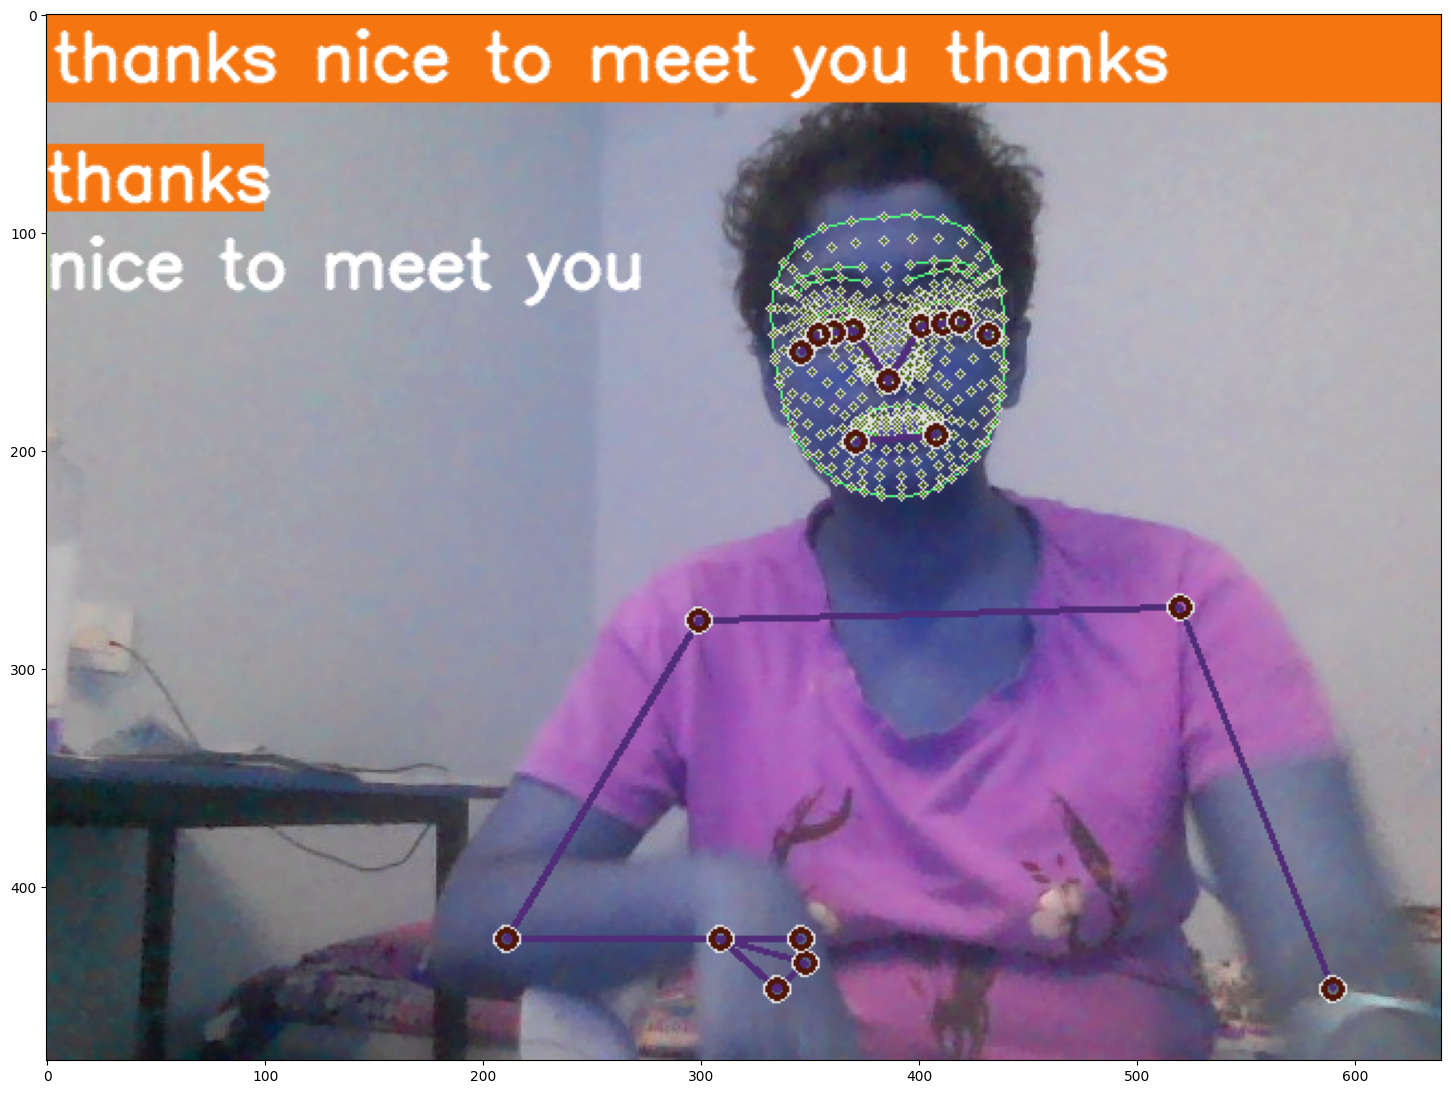

In [66]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))